# Alternative Facts 
### Detecting Fake News with BERT and GNN's 
### Final Project - w266 Natural Language Processing Summer 2023
#### Mike Christenson

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import pydot
import graphviz
from datasets import load_dataset
from transformers import BertTokenizer, TFBertModel
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt

In [1]:
tf.config.list_physical_devices('GPU')

In [2]:
liar_train = pd.DataFrame(load_dataset('liar', split='train'))
train_labels = liar_train['label']
liar_val = pd.DataFrame(load_dataset('liar', split='validation'))
val_labels = liar_val['label']
liar_test = pd.DataFrame(load_dataset('liar', split='test'))
test_labels = liar_test['label']

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Exploratory Data Analysis

Exploring the data thoroughly before getting carried away building models is an essential starting point. The LIAR baseline data includes N columns

#### Class Balance

Text(0.5, 1.0, 'Class Distribution')

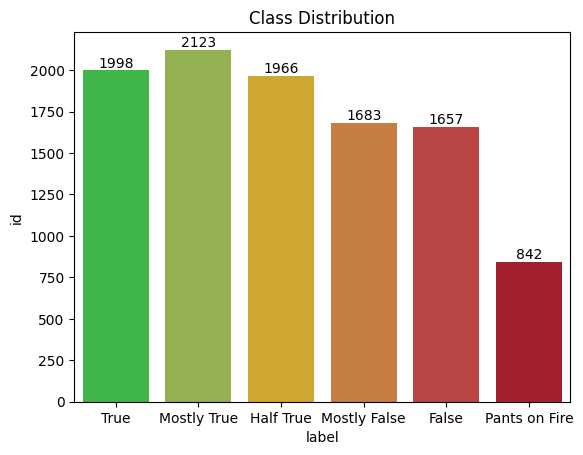

In [6]:
class_counts = liar_train.groupby('label', as_index=False).count()
colors = ['#2DC937', '#99C140', '#E7B416', '#DB7B2B', '#CC3232', '#B60A1C']
p = sns.barplot(data=class_counts, x='label', y="id",  hue="label", palette=colors, dodge=False)
total_labels = liar_train.shape[0]
for x in p.containers:
    p.bar_label(x,)
p.legend_.remove()
p.set_xticklabels(['True', 'Mostly True', 'Half True', 'Mostly False', 'False', 'Pants on Fire'])
p.set_title('Class Distribution')

#### Truth Ratio

The truth ratio refers to the fraction of the total classified statements for a given speaker that fall into a given class. The quantity of total statements 

In [7]:
speaker_label_counts = liar_train.groupby(['speaker', 'label'], as_index=False).count().sort_values(by='id', ascending=False)[['speaker', 'label', 'id']]
speaker_df = speaker_label_counts.pivot_table('id', 'speaker', 'label').reset_index(inplace=False)
speaker_df['total'] = speaker_df[[0, 1, 2, 3, 4, 5]].sum(axis=1)
truth_ratio = speaker_df.copy()
truth_ratio[[0, 1, 2, 3, 4, 5]] = truth_ratio[[0, 1, 2, 3, 4, 5]].div(truth_ratio['total'], axis=0)
speaker_df = speaker_df.rename(columns={0: 'true', 1: 'mostly_true', 2: 'half_true', 3: 'mostly_false', 4: 'false', 5: 'pants_on_fire'})
truth_ratio = truth_ratio.rename(columns={0: 'true', 1: 'mostly_true', 2: 'half_true', 3: 'mostly_false', 4: 'false', 5: 'pants_on_fire'})
truth_ratio.set_index('speaker', inplace=True)

In [8]:
def speaker_truth_ratio_plots(speakers, data):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_indices = [[0, 0], [0, 1], [1, 0], [1, 1]]
    
    for ii in range(len(speakers)):
        pindex = plot_indices[ii]
        p_target = ax[pindex[0], pindex[1]]
        speaker_data = data.loc[speakers[ii], ['true', 'mostly_true', 'half_true', 'mostly_false', 'false', 'pants_on_fire']]
        speaker_columns = speaker_data.index.to_list()
        colors = ['#2DC937', '#99C140', '#E7B416', '#DB7B2B', '#CC3232', '#B60A1C']
        sns.barplot(x=speaker_columns, y=speaker_data.values, palette=colors, ax=p_target)
        for p in p_target.patches:
            p_target.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
                fontsize=10, color='black', ha='center', va='bottom')
        p_target.set_xticklabels(['True', 'Mostly True', 'Half True', 'Mostly False', 'False', 'Pants on Fire'])
        p_target.set_ylim([0, 0.4])
        p_target.set_title(f"{speakers[ii]} class Ratios")

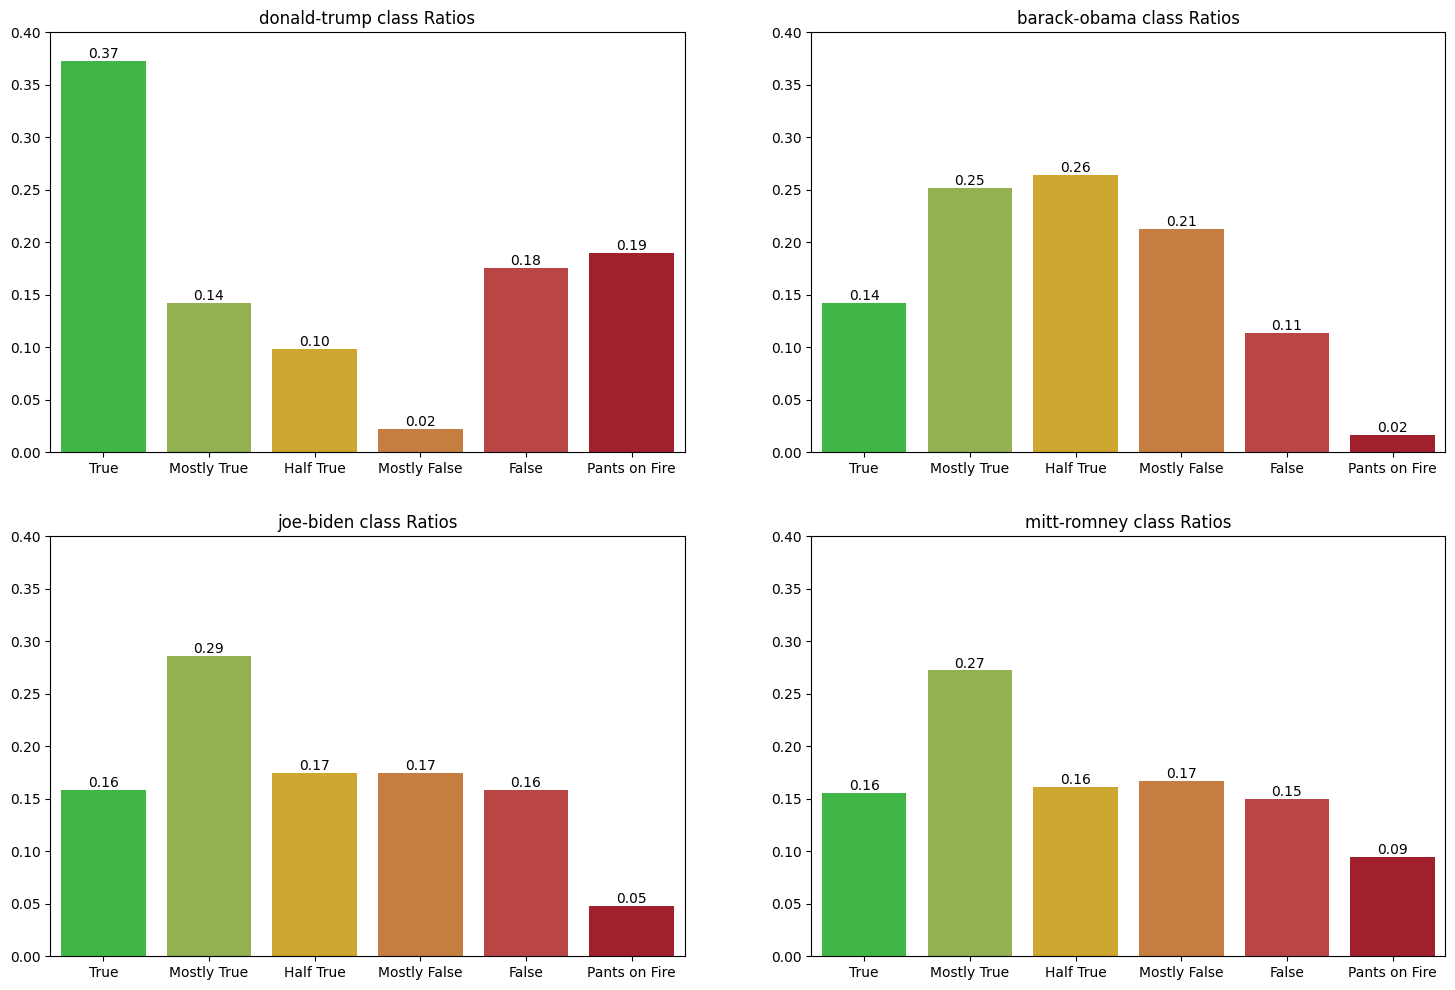

In [9]:
speaker_truth_ratio_plots(['donald-trump', 'barack-obama', 'joe-biden', 'mitt-romney'], truth_ratio)

### Statement Length

In [10]:
liar_train['statement_length'] = list(map(len, liar_train['statement'].str.split(" ")))

Text(0.5, 1.0, 'Statement Length Distribution- Untokenized')

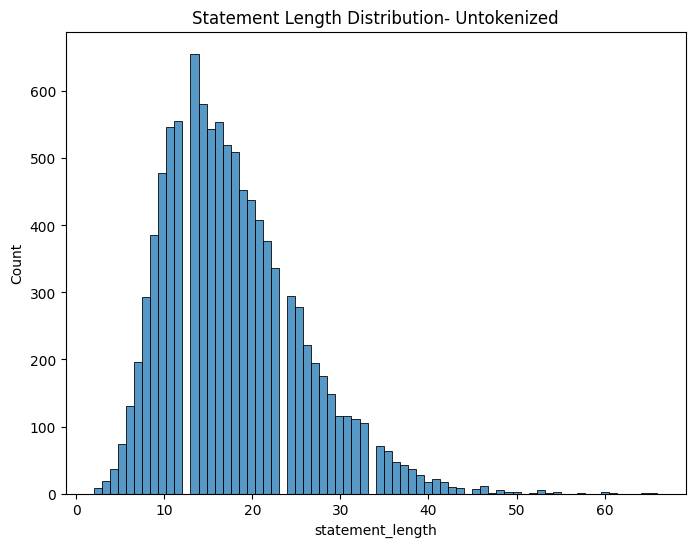

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
hist_plot = sns.histplot(data=liar_train, x='statement_length', ax=ax)
hist_plot.set_title("Statement Length Distribution- Untokenized")

In [44]:
MAX_LENGTH = 200
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
train_tokens = bert_tokenizer(liar_train['statement'].to_list(), max_length=MAX_LENGTH, truncation=True, padding='max_length', return_tensors='tf')
val_tokens = bert_tokenizer(liar_val['statement'].to_list(), max_length=MAX_LENGTH, truncation=True, padding='max_length', return_tensors='tf')
test_tokens = bert_tokenizer(liar_test['statement'].to_list(), max_length=MAX_LENGTH, truncation=True, padding='max_length', return_tensors='tf')


## Baseline Model - BERT + CNN

In [45]:
def bert_multiclass_model(checkpoint = 'bert-base-cased', num_classes=6, hidden_size=200, dropout=0.3, learning_rate=0.00005):
    """"""

     # Make sure the bert model is fully trainable
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    bert_model.trainable = True

    # Create the input layers
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int64, name='attention_mask')

    # Feed those inputs into a bert model
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # Take the pooler token ouput from the BERT outputs
    bert_out = bert_model(bert_inputs)
    pooler_token = bert_out[1]
    pooler_token._name = 'pooler_token'

    # Add the hidden layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden')(pooler_token)
    dropout = tf.keras.layers.Dropout(dropout)(hidden)

    # Add the final classification layer
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='multi_class')(dropout)


    # Connect and compile the model
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',
                                 metrics='accuracy'
    )

    return classification_model

In [46]:
model1 = bert_multiclass_model(checkpoint='bert-base-cased', num_classes=6, )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [47]:
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',        

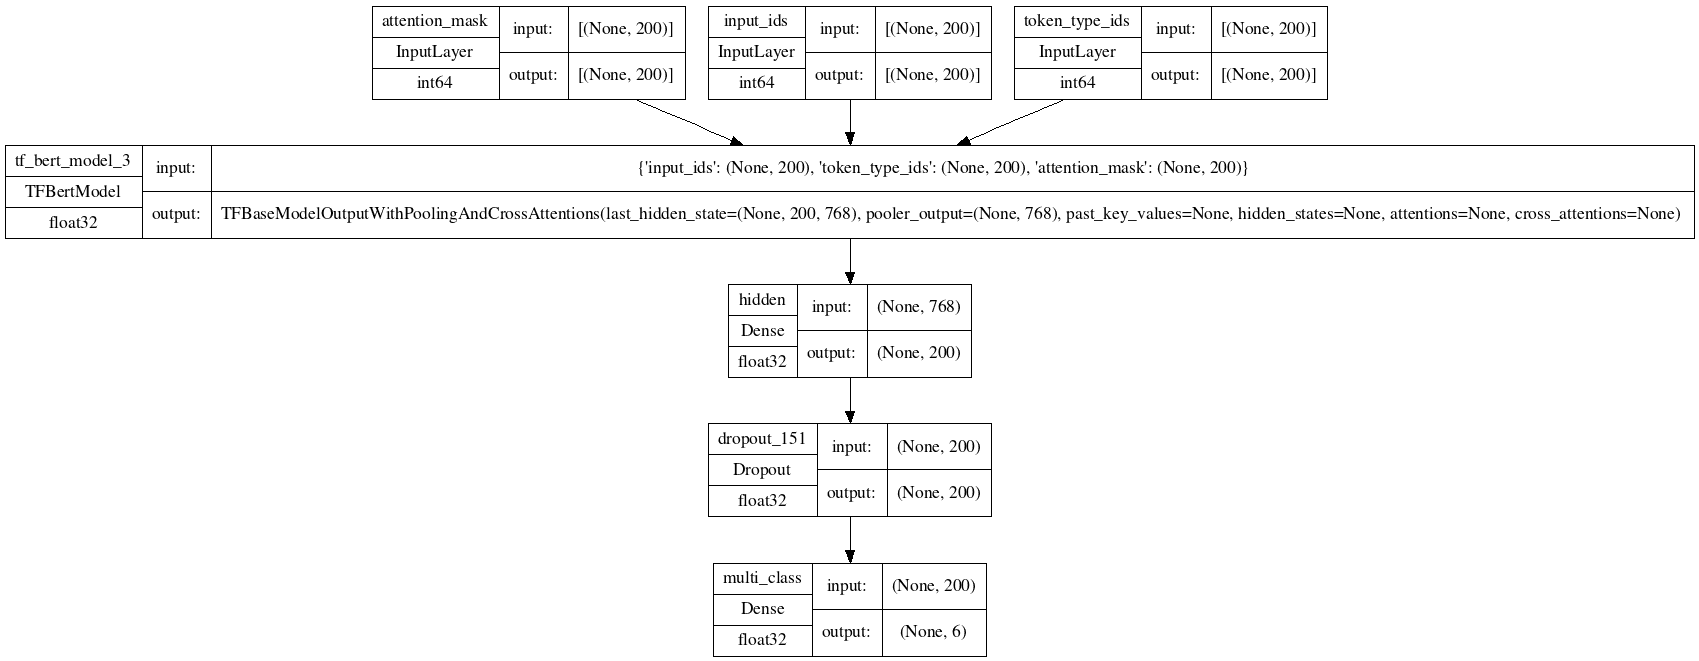

In [48]:
keras.utils.plot_model(model1, show_shapes=True, show_dtype=True, show_layer_names=True, dpi=90)

In [50]:
model1_history = model1.fit([train_tokens.input_ids, train_tokens.token_type_ids, train_tokens.attention_mask],
                                                  train_labels,
                                                  validation_data=([val_tokens.input_ids, val_tokens.token_type_ids, val_tokens.attention_mask],
                                                  val_labels),
                                                  batch_size=8,
                                                  epochs=10)

Epoch 1/10
1284/1284 [==============================] - 143s 111ms/step - loss: 1.6960 - accuracy: 0.2563 - val_loss: 1.7159 - val_accuracy: 0.2539
Epoch 2/10
1284/1284 [==============================] - 139s 108ms/step - loss: 1.5949 - accuracy: 0.3214 - val_loss: 1.7251 - val_accuracy: 0.2586
Epoch 3/10
1284/1284 [==============================] - 141s 110ms/step - loss: 1.4189 - accuracy: 0.4099 - val_loss: 1.8354 - val_accuracy: 0.2547
Epoch 4/10
1284/1284 [==============================] - 137s 106ms/step - loss: 1.2868 - accuracy: 0.4614 - val_loss: 1.7835 - val_accuracy: 0.2445
Epoch 5/10
1284/1284 [==============================] - 141s 110ms/step - loss: 1.1506 - accuracy: 0.5492 - val_loss: 2.1370 - val_accuracy: 0.2477
Epoch 6/10
1284/1284 [==============================] - 114s 89ms/step - loss: 0.8325 - accuracy: 0.6796 - val_loss: 2.7181 - val_accuracy: 0.2562
Epoch 7/10
1284/1284 [==============================] - 114s 89ms/step - loss: 0.6095 - accuracy: 0.7813 - val_lo

In [52]:
model1_history.history

{'loss': [1.6960270404815674,
  1.5948622226715088,
  1.418913722038269,
  1.2867953777313232,
  1.150644302368164,
  0.8325058817863464,
  0.6094937324523926,
  0.47653311491012573,
  0.3932158350944519,
  0.32007282972335815],
 'accuracy': [0.25630539655685425,
  0.32135552167892456,
  0.4098743796348572,
  0.46138864755630493,
  0.5492258071899414,
  0.679618239402771,
  0.7812834978103638,
  0.8298763036727905,
  0.8601616621017456,
  0.8878176808357239],
 'val_loss': [1.715867042541504,
  1.7250746488571167,
  1.8353809118270874,
  1.783516526222229,
  2.137037992477417,
  2.7181248664855957,
  2.742875814437866,
  3.1351726055145264,
  3.187837600708008,
  3.6542367935180664],
 'val_accuracy': [0.2538940906524658,
  0.2585669755935669,
  0.2546728849411011,
  0.24454829096794128,
  0.24766355752944946,
  0.25623053312301636,
  0.2585669755935669,
  0.24610592424869537,
  0.2850467264652252,
  0.24376946687698364]}

In [71]:
def show_history(model_history, model_name):
    history = model_history.history
    history_df = pd.DataFrame(list(zip(history['accuracy'], history['val_accuracy'])), columns=['train', 'validation'])
    plot = sns.lineplot(data=history_df)
    plot.set_xlabel('Epoch')
    plot.set_ylabel('Accuracy')
    plot.set_title(f'{model_name}')



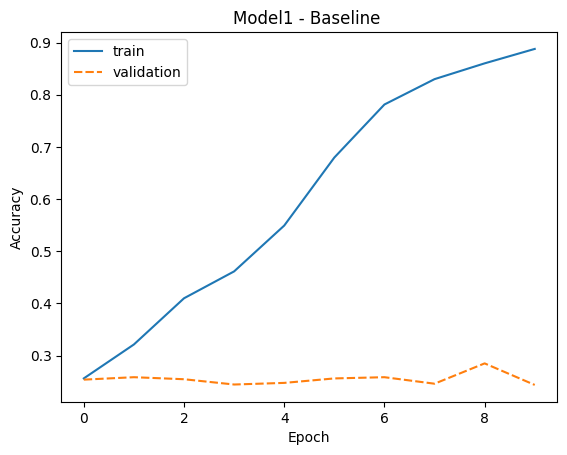

In [72]:
show_history(model1_history, "Model1 - Baseline ")

NameError: name 'show_history' is not defined